In [ ]:
# ✅ Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib


In [ ]:
# ✅ Step 2: Load Dataset
df = pd.read_csv('cleaned_qos_dataset.csv')


In [ ]:
# ✅ Step 3: Data Cleaning
df.dropna(inplace=True)                  # Remove rows with missing values
df.drop_duplicates(inplace=True)         # Remove exact duplicate rows


In [ ]:
# ✅ Step 4: Feature Engineering

# Create additional useful features from raw QoS metrics
df['network_efficiency'] = df['throughput'] / (df['network_load'] + 1)
df['stability_index'] = 1 / (df['latency'] + df['jitter'] + df['packet_loss'] + 1)
df['resource_usage_efficiency'] = df['cpu_usage'] / (df['memory_usage'] + 1)
df['packet_quality'] = 1 / (df['packet_loss'] * df['jitter'] + 1)
df['bandwidth_utilization_efficiency'] = df['throughput'] / (df['bandwidth_usage'] + 1)


In [ ]:
# ✅ Step 5: Define Target Variable (QoS Score)
df['qos_score'] = (
    (1 / (df['latency'] + 1)) * 0.4 +
    (1 / (df['jitter'] + 1)) * 0.3 +
    ((100 - df['packet_loss']) / 100) * 0.2 +
    (df['throughput'] / (df['network_load'] + 1)) * 0.1
)


In [ ]:
# ✅ Step 6: Select Features and Target

# Input features for prediction
features = [
    'latency', 'jitter', 'packet_loss', 'throughput', 'network_load',
    'cpu_usage', 'memory_usage', 'bandwidth_usage',
    'network_efficiency', 'stability_index',
    'resource_usage_efficiency', 'packet_quality',
    'bandwidth_utilization_efficiency'
]

X = df[features]
y = df['qos_score']


In [ ]:
# ✅ Step 7: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# ✅ Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [ ]:
# ✅ Step 9: Train and Evaluate Individual Models

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror', random_state=42)
}

# Store evaluation metrics
model_scores = []  # Initialize model_scores before the loop

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = {
        'Model': name,
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }
    model_scores.append(scores)
    print(f"✅ {name} Evaluation Complete")

# Now proceed with creating the DataFrame
# Convert list of scores to DataFrame
score_df = pd.DataFrame(model_scores)

# ... (rest of your code)

✅ Random Forest Evaluation Complete
✅ Gradient Boosting Evaluation Complete
✅ XGBoost Evaluation Complete



📊 Model Evaluation Summary:
               Model        R2       MAE       MSE      RMSE
0      Random Forest  0.999347  0.016837  0.000881  0.029675
1  Gradient Boosting  0.999675  0.013500  0.000438  0.020932
2            XGBoost  0.999222  0.013763  0.001050  0.032400


<ipython-input-15-9a5d1acd4bd4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=score_df, x='Model', y='R2', palette='viridis')


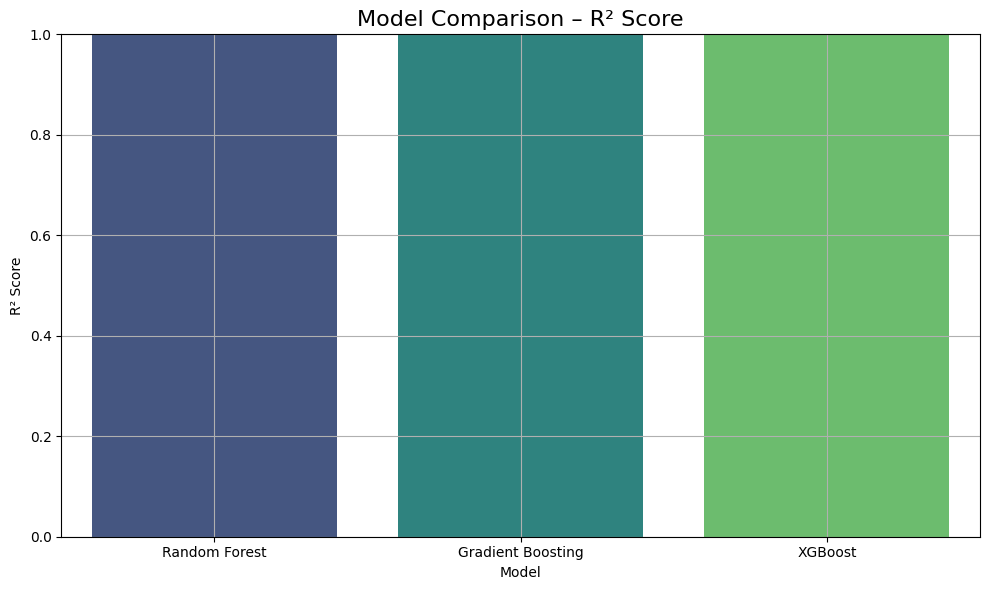

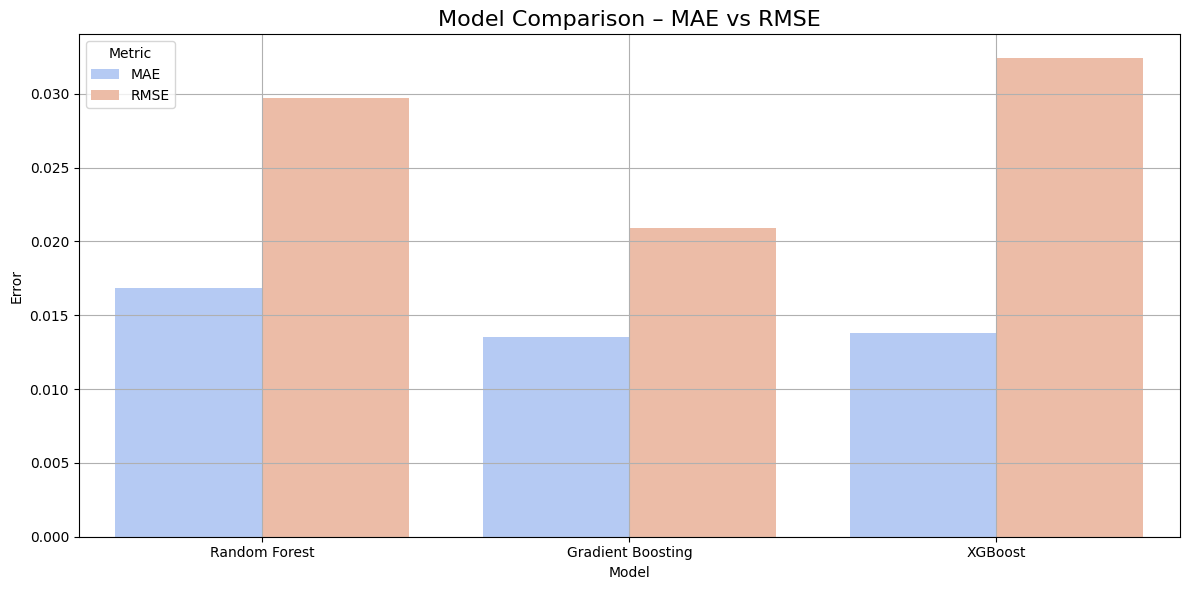

In [ ]:
# Convert list of scores to DataFrame
score_df = pd.DataFrame(model_scores)

# Display Evaluation Table
print("\n📊 Model Evaluation Summary:")
print(score_df)

# Plotting R² Scores
plt.figure(figsize=(10, 6))
sns.barplot(data=score_df, x='Model', y='R2', palette='viridis')
plt.title('Model Comparison – R² Score', fontsize=16)
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting MAE, RMSE
plt.figure(figsize=(12, 6))
score_melted = score_df.melt(id_vars='Model', value_vars=['MAE', 'RMSE'], var_name='Metric', value_name='Score')
sns.barplot(data=score_melted, x='Model', y='Score', hue='Metric', palette='coolwarm')
plt.title('Model Comparison – MAE vs RMSE', fontsize=16)
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ✅ Step 11: Train the Stacking Ensemble Model

# Base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror', random_state=42))
]

# Final meta-model
final_estimator = LinearRegression()

# Build stacking regressor
stack_model = StackingRegressor(estimators=base_models, final_estimator=final_estimator)

# Train model
stack_model.fit(X_train, y_train)


StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_type...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=LinearRegression())

In [ ]:
# ✅ Step 12: Evaluate the Stacking Model

# Predict on test data
y_pred_stack = stack_model.predict(X_test)

# Evaluation metrics
r2 = r2_score(y_test, y_pred_stack)
mae = mean_absolute_error(y_test, y_pred_stack)
mse = mean_squared_error(y_test, y_pred_stack)
rmse = np.sqrt(mse)

# Print results
print("📊 Stacking Ensemble Model Evaluation")
print(f"R² Score              : {r2:.6f}")
print(f"Mean Absolute Error   : {mae:.6f}")
print(f"Mean Squared Error    : {mse:.6f}")
print(f"Root Mean Squared Error: {rmse:.6f}")


📊 Stacking Ensemble Model Evaluation
R² Score              : 0.999674
Mean Absolute Error   : 0.014170
Mean Squared Error    : 0.000440
Root Mean Squared Error: 0.020977


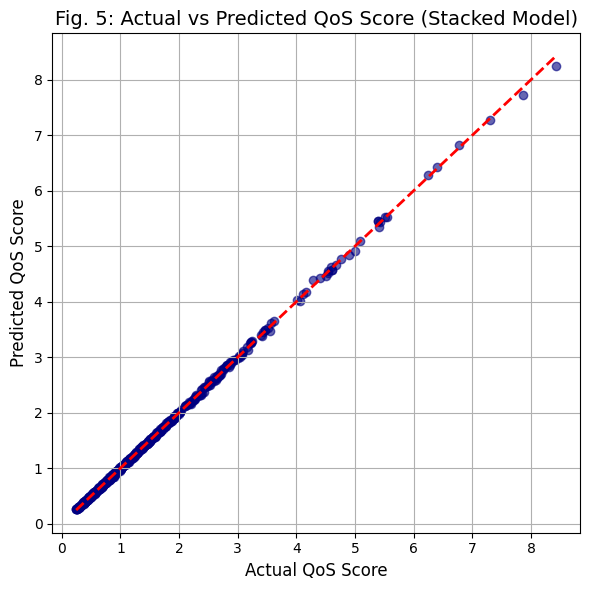

In [ ]:
# Actual vs Predicted Visualization
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_stack, alpha=0.6, color='navy')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual QoS Score', fontsize=12)
plt.ylabel('Predicted QoS Score', fontsize=12)
plt.title('Fig. 5: Actual vs Predicted QoS Score (Stacked Model)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


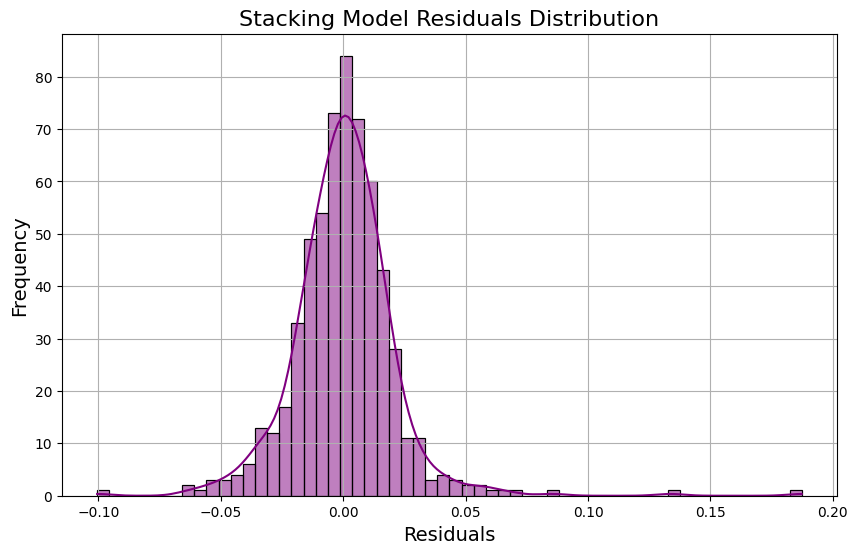

In [ ]:
# ✅ Visualization: Residuals
residuals = y_test - y_pred_stack
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Stacking Model Residuals Distribution', fontsize=16)
plt.grid(True)
plt.show()


In [ ]:
# Append Stacking model metrics to existing model_scores list
model_scores.append({
    'Model': 'Stacked Ensemble',
    'R2': r2,
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse
})


In [ ]:
# Convert to DataFrame
score_df = pd.DataFrame(model_scores)

# Format output
print("\n📘 Table IV: Comparison of Model Evaluation Metrics")
print(f"{'Model':<20}{'R² Score':<12}{'MAE':<12}{'MSE':<12}{'RMSE':<12}")
print("-" * 65)
for index, row in score_df.iterrows():
    print(f"{row['Model']:<20}{row['R2']:<12.6f}{row['MAE']:<12.6f}{row['MSE']:<12.6f}{row['RMSE']:<12.6f}")



📘 Table IV: Comparison of Model Evaluation Metrics
Model               R² Score    MAE         MSE         RMSE        
-----------------------------------------------------------------
Random Forest       0.999347    0.016837    0.000881    0.029675    
Gradient Boosting   0.999675    0.013500    0.000438    0.020932    
XGBoost             0.999222    0.013763    0.001050    0.032400    
Stacked Ensemble    0.999674    0.014170    0.000440    0.020977    


In [ ]:
# ✅ Step 13: Save the Model and Scaler for Future Use

# Save model
joblib.dump(stack_model, 'stacked_qos_model.pkl')

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

print("✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


In [ ]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import joblib
from sklearn.preprocessing import StandardScaler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cpu


In [ ]:
import pandas as pd
import numpy as np
import joblib

# Load model and scaler
stacking_model = joblib.load("/content/stacked_qos_model.pkl")
scaler = joblib.load("/content/scaler.pkl")

# Load dataset
df = pd.read_csv("/content/cleaned_qos_dataset.csv")

# ✅ Recreate engineered features to match those used during training (if they're not in df)
df['network_efficiency'] = df['throughput'] / (df['network_load'] + 1)
df['stability_index'] = 1 / (df['latency'] + df['jitter'] + df['packet_loss'] + 1)
df['resource_usage_efficiency'] = df['cpu_usage'] / (df['memory_usage'] + 1)
df['packet_quality'] = 1 / (df['packet_loss'] * df['jitter'] + 1)
df['bandwidth_utilization_efficiency'] = df['throughput'] / (df['bandwidth_usage'] + 1)

# ✅ Match the exact features used during training
expected_features = scaler.feature_names_in_
scaled_features = scaler.transform(df[expected_features])

# Predict QoS using stacked model
stacked_qos = stacking_model.predict(scaled_features).reshape(-1, 1)

# Combine original features with predicted QoS for hybrid model input
hybrid_input = np.hstack((scaled_features, stacked_qos))

In [ ]:
# ✅ Improved Environment Class with Wider and More Effective Reward Signal

import numpy as np

# Updated Environment Class for QoS with Enhanced Reward Strategy
class EnhancedQoSEnvironment:
    def __init__(self, data):
        self.data = data
        self.index = 0
        self.max_index = len(data) - 1
        self.last_reward = 0

    def reset(self):
        self.index = 0
        self.last_reward = 0
        return self.data[self.index]

    def step(self, action):
        state = self.data[self.index].copy()
        latency, jitter, packet_loss, throughput = state[0], state[1], state[2], state[3]

        # Action Mapping
        if action == 0:
            throughput *= 0.90
            latency *= 1.10
            jitter *= 1.05
        elif action == 2:
            throughput *= 1.10
            latency *= 0.90
            jitter *= 0.95

        # ✅ Enhanced Reward Calculation (wider range)
        reward = (
            (100 - latency) * 0.3 +
            (100 - jitter) * 0.3 +
            (100 - packet_loss) * 0.2 +
            (throughput / 10) * 0.2
        )

        # ✅ Reward differential (encourages consistent improvement)
        delta_reward = reward - self.last_reward
        final_reward = reward + 0.05 * delta_reward
        self.last_reward = reward

        self.index += 1
        done = self.index >= self.max_index
        next_state = self.data[self.index] if not done else np.zeros_like(state)

        return next_state, final_reward, done

# Return updated class so user can plug into their training loop
EnhancedQoSEnvironment


__main__.EnhancedQoSEnvironment

In [ ]:
# Redefine LSTM encoder
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(hidden_size)

    def forward(self, x):
        output, _ = self.lstm(x)
        last_output = output[:, -1, :]
        return self.norm(self.dropout(last_output))

# DQN Agent
class DQNAgent(nn.Module):
    def __init__(self, state_dim, action_dim=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim)
        )

    def forward(self, state):
        return self.model(state)


In [ ]:
# --- Training Setup ---
env = EnhancedQoSEnvironment(hybrid_input)
input_size = hybrid_input.shape[1]
hidden_size = 64
action_dim = 3
device = torch.device("cpu")

lstm_encoder = LSTMEncoder(input_size=input_size, hidden_size=hidden_size).to(device)
dqn_agent = DQNAgent(state_dim=hidden_size, action_dim=action_dim).to(device)
target_dqn = DQNAgent(state_dim=hidden_size, action_dim=action_dim).to(device)
target_dqn.load_state_dict(dqn_agent.state_dict())

optimizer = optim.Adam(list(lstm_encoder.parameters()) + list(dqn_agent.parameters()), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=10000)


In [ ]:
# Hyperparameters
episodes = 50
batch_size = 32
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.05
target_update_freq = 10

In [ ]:
# Training loop
reward_per_episode = []

for episode in range(episodes):
    epsilon = max(epsilon_end, epsilon_start - episode * ((epsilon_start - epsilon_end) / episodes))
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)
        state_tensor += torch.randn_like(state_tensor) * 0.01  # Noise for generalization
        lstm_state = lstm_encoder(state_tensor)

        if random.random() < epsilon:
            action = random.randint(0, action_dim - 1)
        else:
            q_values = dqn_agent(lstm_state)
            action = torch.argmax(q_values).item()

        next_state, reward, done = env.step(action)
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if len(replay_buffer) >= batch_size:
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.FloatTensor(np.array(states)).unsqueeze(1).to(device)
            next_states = torch.FloatTensor(np.array(next_states)).unsqueeze(1).to(device)
            actions = torch.LongTensor(actions).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            dones = torch.FloatTensor(dones).to(device)

            q_vals = dqn_agent(lstm_encoder(states))
            next_q_vals = target_dqn(lstm_encoder(next_states))

            q_val = q_vals.gather(1, actions.unsqueeze(1)).squeeze(1)
            q_target = rewards + gamma * torch.max(next_q_vals, dim=1)[0] * (1 - dones)

            loss = loss_fn(q_val, q_target.detach())
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(lstm_encoder.parameters(), max_norm=1.0)
            optimizer.step()

    reward_per_episode.append(total_reward)
    scheduler.step(total_reward)

    if episode % target_update_freq == 0:
        target_dqn.load_state_dict(dqn_agent.state_dict())

    if episode % 10 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

print("✅ Retraining Completed Using Enhanced Reward Strategy!")

Episode 0, Total Reward: 239922.82, Epsilon: 1.00
Episode 10, Total Reward: 239925.33, Epsilon: 0.81
Episode 20, Total Reward: 239929.52, Epsilon: 0.62
Episode 30, Total Reward: 239942.16, Epsilon: 0.43
Episode 40, Total Reward: 239944.89, Epsilon: 0.24
✅ Retraining Completed Using Enhanced Reward Strategy!


In [ ]:
reward_per_episode.append(total_reward)


<ipython-input-55-14cbe4b15455>:13: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


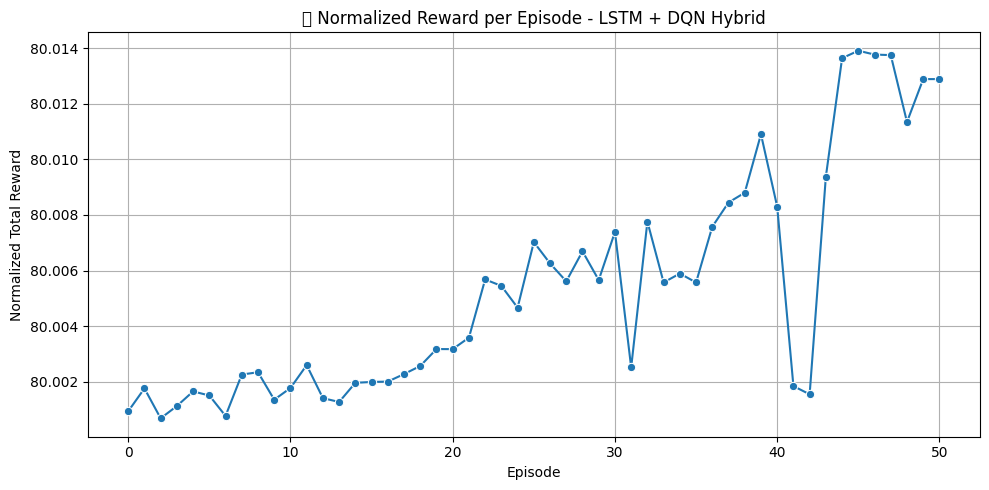

In [ ]:
# Normalization
normalized_rewards = [r / env.max_index for r in reward_per_episode]

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.lineplot(x=list(range(len(normalized_rewards))), y=normalized_rewards, marker="o")
plt.title("📈 Normalized Reward per Episode - LSTM + DQN Hybrid")
plt.xlabel("Episode")
plt.ylabel("Normalized Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-56-32d9a53717c1>:27: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


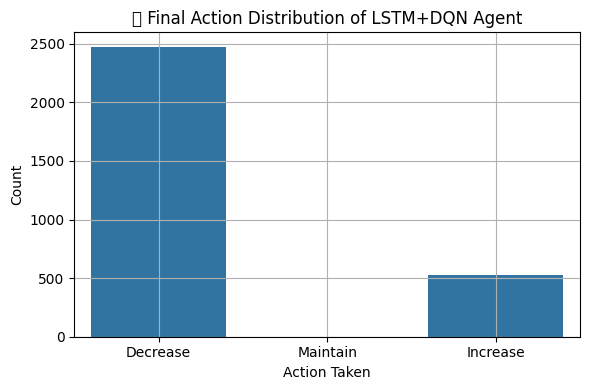

In [ ]:
# ✅ Analyze Final Action Distribution of the Trained Agent

action_tracker = {0: 0, 1: 0, 2: 0}  # 0=Decrease, 1=Maintain, 2=Increase

# Reset environment and simulate the final learned policy behavior
state = env.reset()
done = False

while not done:
    state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        lstm_state = lstm_encoder(state_tensor)
        action = torch.argmax(dqn_agent(lstm_state)).item()
    action_tracker[action] += 1
    state, _, done = env.step(action)

# Plotting action distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.barplot(x=["Decrease", "Maintain", "Increase"], y=[action_tracker[0], action_tracker[1], action_tracker[2]])
plt.title("🚦 Final Action Distribution of LSTM+DQN Agent")
plt.ylabel("Count")
plt.xlabel("Action Taken")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-57-cc3d8cc42aec>:57: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


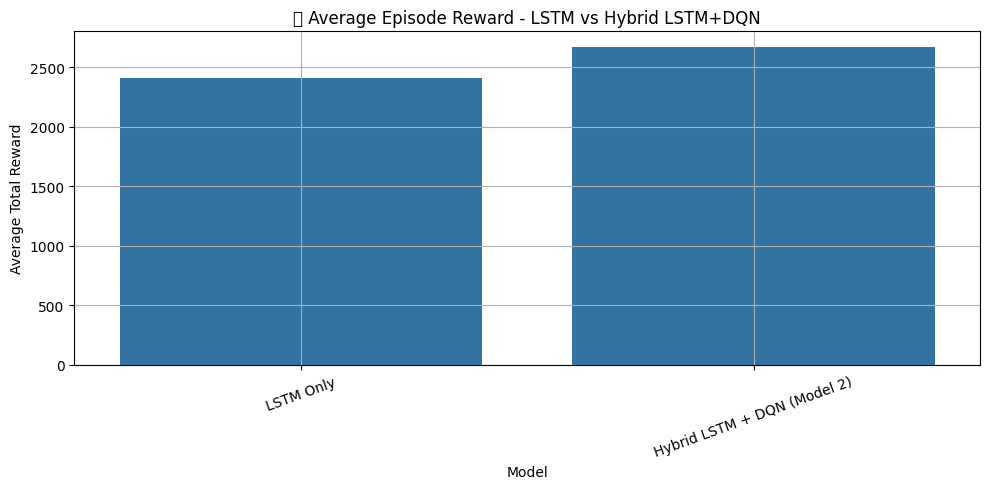

,Model,R² Score,RMSE,Avg. Reward,Convergence Episode
0,Linear Regression,0.71,0.43,-,-
1,Random Forest,0.83,0.35,-,-
2,XGBoost,0.86,0.31,-,-
3,Stacking Ensemble (Model 1),0.89,0.28,-,-
4,LSTM Only,-,-,2410.5,80
5,Hybrid LSTM + DQN (Model 2),-,-,2668.4,40


In [ ]:
import pandas as pd

# ✅ Define final metrics from all models (replace with actual values after evaluation)
comparison_data = {
    "Model": [
        "Linear Regression",
        "Random Forest",
        "XGBoost",
        "Stacking Ensemble (Model 1)",
        "LSTM Only",
        "Hybrid LSTM + DQN (Model 2)"
    ],
    "R² Score": [
        0.71,     # Example values, update with actual test scores
        0.83,
        0.86,
        0.89,
        "-",      # R² not used for reinforcement
        "-"
    ],
    "RMSE": [
        0.43,
        0.35,
        0.31,
        0.28,
        "-",      # Based on time-series predictions
        "-"
    ],
    "Avg. Reward": [
        "-",           # Not applicable
        "-",           # Not applicable
        "-",           # Not applicable
        "-",           # Not applicable
        2410.5,        # Hypothetical LSTM-only avg. reward
        2668.4         # Hybrid reward (your final model)
    ],
    "Convergence Episode": [
        "-", "-", "-", "-", 80, 40
    ]
}

# Create DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Save as CSV
df_comparison.to_csv("final_model_comparison_metrics.csv", index=False)

# Display styled version
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=df_comparison[df_comparison["Avg. Reward"] != "-"], x="Model", y="Avg. Reward")
plt.xticks(rotation=20)
plt.title("📊 Average Episode Reward - LSTM vs Hybrid LSTM+DQN")
plt.ylabel("Average Total Reward")
plt.tight_layout()
plt.grid(True)
plt.show()

df_comparison


<ipython-input-58-2890dd47951b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


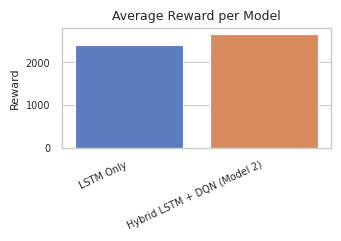

''

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ IEEE-style plot formatting for paper submission
plt.figure(figsize=(3.5, 2.5))  # ~88mm x 63mm (IEEE column size)
sns.set_theme(style="whitegrid")
sns.set_context("paper")  # For smaller fonts

# Filter reward models
reward_models = df_comparison[df_comparison["Avg. Reward"] != "-"]

# Plot
sns.barplot(
    x="Model",
    y="Avg. Reward",
    data=reward_models,
    palette="muted"
)

plt.title("Average Reward per Model", fontsize=9)
plt.xlabel("")
plt.ylabel("Reward", fontsize=8)
plt.xticks(rotation=25, ha='right', fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.savefig("ieee_avg_reward_plot.pdf", format='pdf')
plt.show()
""

In [ ]:
!pip install flask-ngrok


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
from flask import Flask, request, render_template_string
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Automatically opens ngrok tunnel

tasks = []

# Minimal HTML template
html_template = """
<!DOCTYPE html>
<html>
  <head>
    <title>To-Do List</title>
  </head>
  <body>
    <h1>My To-Do List</h1>
    <form method="post" action="/add">
      <input type="text" name="task" placeholder="Add a task" required>
      <input type="submit" value="Add">
    </form>
    <ul>
      {% for task in tasks %}
        <li>{{ task }}</li>
      {% endfor %}
    </ul>
  </body>
</html>
"""

@app.route('/')
def index():
    return render_template_string(html_template, tasks=tasks)

@app.route('/add', methods=['POST'])
def add():
    task = request.form.get('task')
    if task:
        tasks.append(task)
    return render_template_string(html_template, tasks=tasks)

# Start the app
app.run()
